<a href="https://colab.research.google.com/github/simulate111/Production-Optimization/blob/main/circlepacking_empty.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

All installations must be done every time you re-open a notebook and want to run it. Google colab has many packages already installed, which you normally would need to install such as nympy, scipy , matplotlib, plotly, pandas. Most of these also comes with Anaconda (except plotly)

Adding text and code is done with "+ Code" or "+ Text" Sections can easlily be moved or deleted. To run a code you need to press the play buttom that appears when you move the cursor over a code block.

First we install pyomo (in quite mode). Since you will need to use
Runtime->Run all if you re-define a pyomo model, we add a try-except construction to the Python code to check if pyomo is already installed. The "!" allows us to run command (as in a terminal).

For this example we need the NLP solver ipopt. This is distributed with the larger package ideas (and now it seems that this solver should be called as ipopt_l1, this may change again).

In [ ]:
#Install pyomo and solvers from the IDAES project
#this installs several solvers like ipopt, cbc, bonmin but takes some time to run
#ipopt is now under the name ipop_l1
try:
  not_first_time == True
except:
  !pip install idaes-pse --pre
  !idaes get-extensions --to ./bin
  not_first_time = True
finally:
  print("Pyomo and solvers installed")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 26.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 306.8/306.8 kB 8.9 MB/s eta 0:00:00
Getting files...
Done
-----------------------------------------------------------------
IDAES Extensions Build Versions
Solvers:  v3.4.2 20240811 ubuntu2204-x86_64
Library:  v3.4.2 20240811 ubuntu2204-x86_64

Pyomo and solvers installed


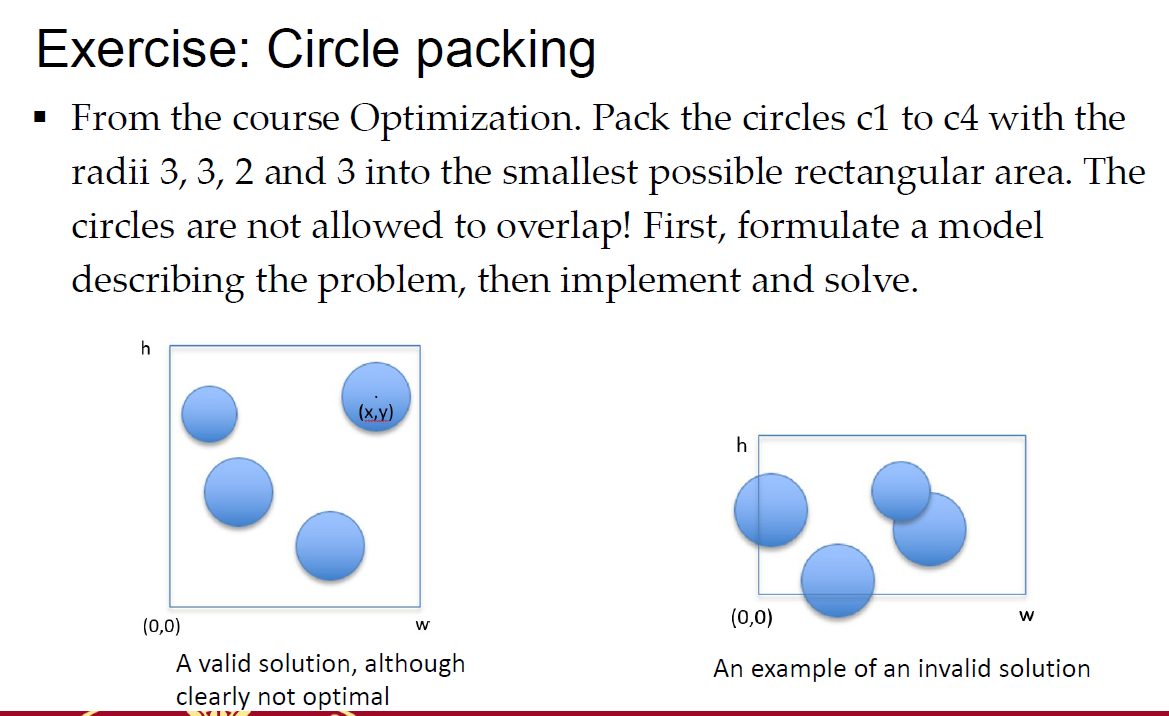

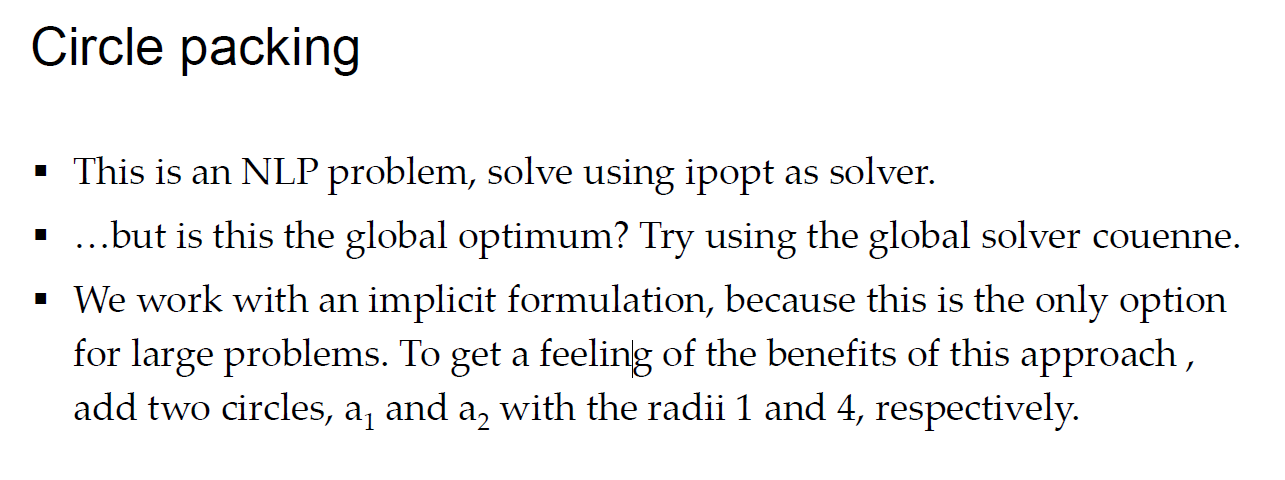

The problem in compact form:

$ \min \: w \cdot h$

s.t

$x_c \ge r_c \:\: \forall c \in C$

$x_c + r_c \le w \:\: \forall c \in C$

$y_c \ge r_c \:\: \forall c \in C$

$y_c + r_c \le h \:\: \forall c \in C$

$(x_c-x_{c^\prime})^2+(y_c-y_{c^\prime})^2 \ge (r_c+r_{c^\prime})^2 \:\: \forall c,c^{\prime} \in C,c \lt c^{\prime}$

$h,w,x_c,y_c \in \mathbb{R}_{\ge 0}, C=\{c_1,c_2,c_3,c_4\}$



The radius of the circles, from 1 to 4, are 3, 3, 2 and 3, respectively.

When you are done with the this problem, add a cicle with your name and a radius

In [ ]:
from pyomo.environ import *
import matplotlib.pyplot as plt
#return this cell if you make changes

m=ConcreteModel()
#Sets Set(initialize=,doc='')

#Parameters Param(initialize={key:values},doc='')

#Variables Var(within=NonNegativeReals,doc='') (Starting guesses can be given with initialize={key:values}, usually no need)

#Objective Objective(expr= , sense=minimize, doc='')

#Constraints Constraint(rule= ,doc='')



#m.pprint()


In [ ]:
#Solve in a separate stage, since we need to build the model first. When ready, one cell would do.
#added path to the executable, seems to be necessary
solver = SolverFactory("ipopt_l1",executable="/content/bin/ipopt_l1") #it used to be ipopt...

#solver = SolverFactory("couenne",executable="/content/bin/couenne") #this may take forever with large problems, restrict time using a opt-file
#with open("couenne.opt","w") as file:
#    file.write("time_limit 30")

results = solver.solve(m, keepfiles=False, tee=True)
#m.display()

ValueError: No variables appear in the Pyomo model constraints or objective. This is not supported by the NL file interface

In [ ]:
#Code for plotting the solution
figure, axes = plt.subplots()
for c in m.C:
    draw_circle = plt.Circle((m.x[c].value, m.y[c].value),m.r[c] )
    axes.add_artist(draw_circle)
    axes.text(m.x[c].value, m.y[c].value, c,
         horizontalalignment='center', verticalalignment='center')

plt.plot([0, m.w.value],[m.h.value, m.h.value])
plt.plot([m.w.value,m.w.value],[0, m.h.value])
axes.set_aspect(1)

plt.xlim(0,m.w.value+2)
plt.ylim(0,m.h.value+2)
plt.show()

In [ ]:
#Importing using Pandas dataframes from Excel is practical. For a simple Excel file with headers in the first row and data i cells below this works
#(there are many ways to do the same thing)

#import pandas as pd
#
#df = pd.read_excel('circle_data.xlsx') #you need to upload the file to colab each session
#m.C = Set(initialize=df.set_index('circles').index.to_list(),doc='Circles')
#m.r = Param(m.C,initialize=df.set_index('circles')['radius'].to_dict(),doc='Radius of circle')



In [ ]:
#something on dataframes

#df2=df.set_index('circles') #creates a new dataframe that has circles as indices
#df2['radius'] #getting the elements in the column 'radius' as a series
#df2['radies'].to_dict() #convert the series to a dictionary
#df.set_index('circles')['radius'].to_dict() #everything in one step